In [1]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker

import rasterio
import shapely
from shapely.geometry import LineString, Polygon

import flopy
from flopy.discretization import StructuredGrid, VertexGrid
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from flopy.utils.gridgen import Gridgen
import flopy.plot.styles as styles

In [2]:
# import all plot style information from defaults.py
from defaults import *

### Load raster data

In [3]:
kaq = flopy.utils.Raster.load("./data/k_aq.asc")
kclay = flopy.utils.Raster.load("./data/k_clay.asc")
top_base = flopy.utils.Raster.load("./data/top.asc")
bot = flopy.utils.Raster.load("./data/bottom.asc")
lake_location = flopy.utils.Raster.load("./data/lake_location.asc")

### create a structured grid for plotting

In [4]:
nlay, nrow, ncol = 5, 40, 25
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)
delr, delc = 500.0, 500.0
delrs = np.ones(ncol, dtype=np.float32) * delr
delcs = np.ones(nrow, dtype=np.float32) * delc
top = top_base.get_array(1)
botm = np.zeros(shape3d, dtype=np.float32)
botm[0] = -5.0
botm[1] = -50.0
botm[2] = -51.0
botm[3] = -100.0
botm[4] = bot.get_array(1)

In [5]:
struct_grid = flopy.discretization.StructuredGrid(
    nlay=1,
    nrow=nrow,
    ncol=ncol,
    delr=delrs,
    delc=delcs,
    top=top,
    botm=botm[0].reshape((1, nrow, ncol)),
)

### define the features

In [6]:
mv_boundary = """0.0 0.0
0.0 20000.0
12500.0 20000.0
12500.0 0.0"""

In [7]:
river = """4250.0 8750.0 
4250.0 0.0"""

In [8]:
river_box = """3500.0 0.0
3500.0 9500.0
5000.0 9500.0
5000.0 0.0"""

In [9]:
wells = """7250. 17250.
7750. 2750.
2750 3750."""

In [10]:
lake = """1500. 18500.
3500. 18500.
3500. 15500.
4000. 15500.
4000. 14500.
4500. 14500.
4500. 12000.
2500. 12000.
2500. 12500.
2000. 12500.
2000. 14000.
1500. 14000.
1500. 15000.
1000. 15000.
1000. 18000.
1500. 18000."""

In [11]:
boundary_refinement = 500.0
river_refinement = 50.0
lake_refinement = 100.0
max_boundary_area = boundary_refinement * boundary_refinement
max_river_area = river_refinement * river_refinement
max_lake_area = lake_refinement * lake_refinement

In [12]:
boundary_polygon = string2geom(mv_boundary)
print("len boundary", len(boundary_polygon))
bp = np.array(boundary_polygon)
bp_densify = np.array(densify_geometry(bp, boundary_refinement))

len boundary 4


In [13]:
river_polyline = string2geom(river)
sg = np.array(river_polyline)
sg_densify = np.array(densify_geometry(sg, river_refinement))

In [14]:
river_boundary = string2geom(river_box)
rb = np.array(river_boundary)
rb_densify = np.array(densify_geometry(rb, river_refinement))

In [15]:
lake_polygon = string2geom(lake)
lake_plot = string2geom(lake)
lake_plot += [lake_plot[0]]
lake_plot = np.array(lake_plot)
lp = np.array(lake_polygon)
lp_densify = np.array(densify_geometry(lp, lake_refinement))

In [16]:
well_points = string2geom(wells)
wp = np.array(well_points)

#### simple plotting functions

In [17]:
def plot_wells(ax=None, ms=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(wp[:, 0], wp[:, 1], "ro", ms=ms)
    return ax

In [18]:
def plot_river(
    ax=None,
):
    if ax is None:
        ax = plt.gca()
    ax.plot(sg_densify[:, 0], sg_densify[:, 1], **river_dict)
    return ax

In [19]:
def plot_lake(ax=None, lw=0.5, color="cyan"):
    if ax is None:
        ax = plt.gca()
    ax.plot(lake_plot[:, 0], lake_plot[:, 1], ls="-", color=color, lw=lw)
    return ax

In [20]:
def plot_circles(ax=None, radius=1.0, lw=0.5, color="red"):
    if ax is None:
        ax = plt.gca()
    for pt in wp:
        center = (pt[0], pt[1])
        pts = circle_function(center=center, radius=radius)
        ax.plot(pts[:, 0], pts[:, 1], ls=":", color=color, lw=lw)
    return ax

### plot the features

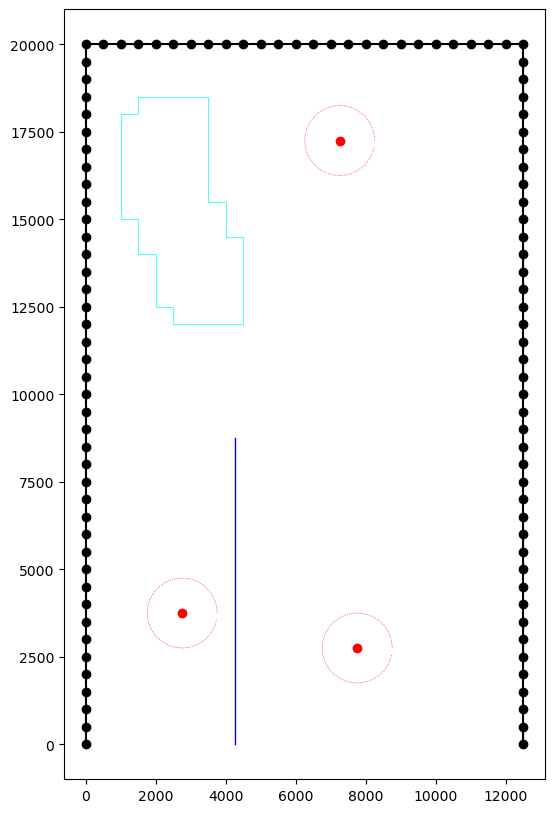

In [21]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.set_aspect("equal")

ax.plot(bp_densify[:, 0], bp_densify[:, 1], "ko-")
plot_lake(ax)
plot_river(ax)
plot_wells(ax)
plot_circles(ax, radius=1000);

### use Triangle to create mesh

In [22]:
temp_path = "triangle_data"

In [23]:
maximum_area = 500.0 * 500.0
well_dv = 1000.0

In [24]:
tri = Triangle(
    angle=30,
    nodes=sg_densify,
    model_ws=temp_path,
)
tri.add_polygon(bp_densify)
tri.add_polygon(rb_densify)
tri.add_polygon(lp_densify)
tri.add_region((0.1, 0.1), attribute=10, maximum_area=max_boundary_area)
tri.add_region(
    (10000.0, 10000.0), attribute=10, maximum_area=max_boundary_area
)
tri.add_region((3000.0, 15000.0), attribute=11, maximum_area=max_lake_area)
tri.add_region((4000.0, 500.0), attribute=10, maximum_area=max_river_area)
for idx, w in enumerate(wp):
    center = (w[0], w[1])
    tri.add_polygon(circle_function(center=center, radius=400.0))
    tri.add_region(center, attribute=idx, maximum_area=10000.0)
tri.build(verbose=False)

<AxesSubplot:>

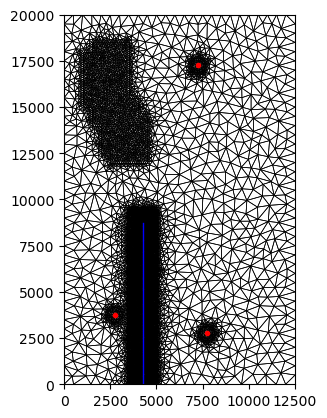

In [25]:
tri.plot(lw=0.5)
ax = plot_wells(ms=3)
plot_river(ax)

### convert triangular mesh to a voronoi grid

In [26]:
vor = VoronoiGrid(tri)

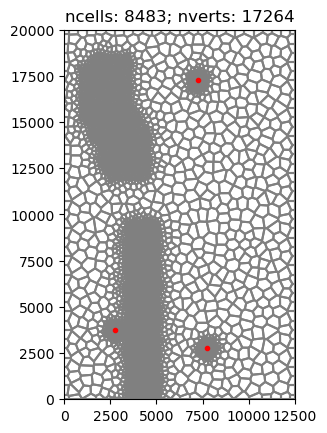

In [27]:
vor.plot()
ax = plot_wells(ms=3)

### create a flopy Vertex grid to use for the model

In [28]:
gridprops = vor.get_gridprops_vertexgrid()
idomain = np.ones((1, vor.ncpl), dtype=int)
voronoi_grid = VertexGrid(**gridprops, nlay=1, idomain=idomain)

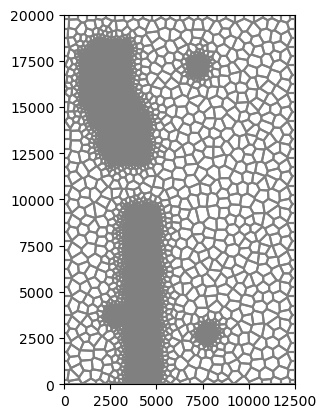

In [29]:
voronoi_grid.plot()

### intersect the rasters with the vertex grid

In [30]:
top_vg = top_base.resample_to_grid(
    voronoi_grid,
    band=top_base.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [31]:
bot_vg = bot.resample_to_grid(
    voronoi_grid,
    band=bot.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [32]:
lake_cells_vg = lake_location.resample_to_grid(
    voronoi_grid,
    band=kaq.bands[0],
    method="nearest",
    extrapolate_edges=True,
)

In [33]:
kaq_vg = kaq.resample_to_grid(
    voronoi_grid,
    band=kaq.bands[0],
    method="nearest",
    extrapolate_edges=True,
)

In [34]:
kclay_vg = kclay.resample_to_grid(
    voronoi_grid,
    band=kclay.bands[0],
    method="nearest",
)

In [35]:
top_vg.shape

(8483,)

### plot the resampled rasters

In [36]:
two_panel_figsize = (17.15 / 2.541, 0.8333 * 17.15 / 2.541)
one_panel_figsize = (8.25 / 2.541, 13.2 / 2.541)

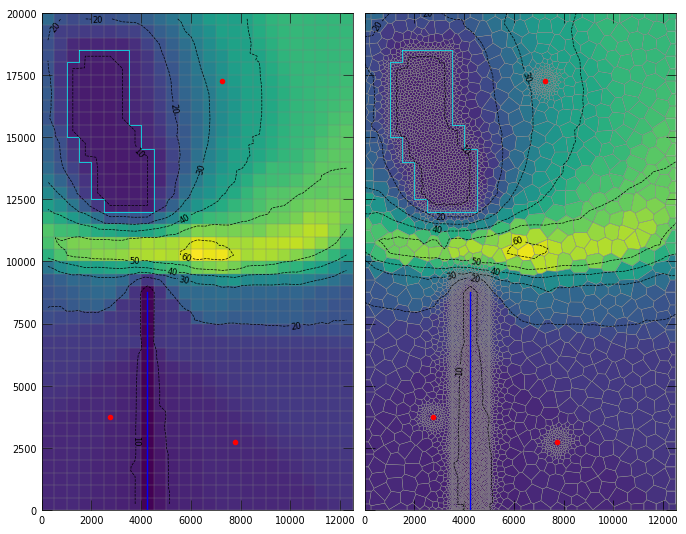

In [37]:
vmin, vmax = 5, 65
with styles.USGSMap():
    fig, [ax1, ax2] = plt.subplots(
        1,
        2,
        sharey=True,
        figsize=two_panel_figsize,
        constrained_layout=True,
        subplot_kw=dict(aspect="equal"),
    )
    ax = ax1
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(top_base.get_array(1), vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)
    cs = mm.contour_array(
        top_base.get_array(1),
        **contour_dict,
    )
    ax.clabel(cs, **clabel_dict)

    ax = ax2
    mm = flopy.plot.PlotMapView(modelgrid=voronoi_grid, ax=ax)
    mm.plot_array(top_vg.reshape(1, voronoi_grid.ncpl), vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)
    cs = mm.contour_array(
        top_vg,
        **contour_dict,
    )
    ax.clabel(cs, **clabel_dict)

    fpth = "figures/mv_voronoi_top.png"
    plt.savefig(fpth, dpi=300);

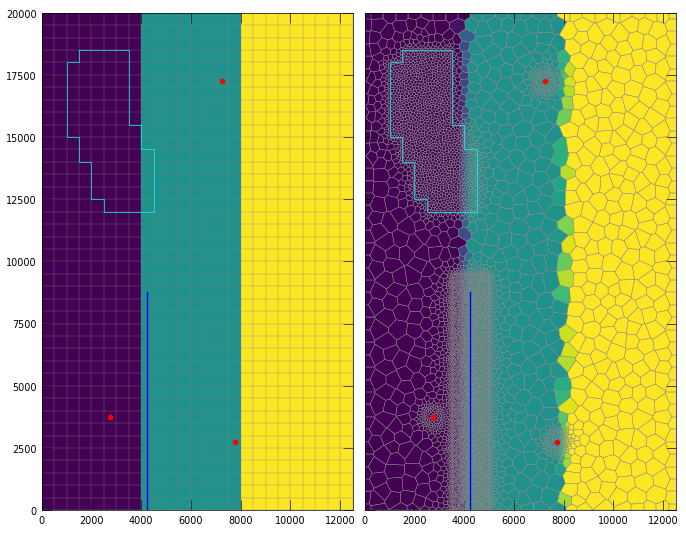

In [38]:
vmin, vmax = -250, -150
with styles.USGSMap():
    fig, [ax1, ax2] = plt.subplots(
        1,
        2,
        sharey=True,
        figsize=two_panel_figsize,
        constrained_layout=True,
        subplot_kw=dict(aspect="equal"),
    )
    ax = ax1
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(bot.get_array(1), vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)

    ax = ax2
    mm = flopy.plot.PlotMapView(modelgrid=voronoi_grid, ax=ax)
    mm.plot_array(bot_vg, vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)

    fpth = "figures/mv_voronoi_bot.png"
    plt.savefig(fpth, dpi=300);

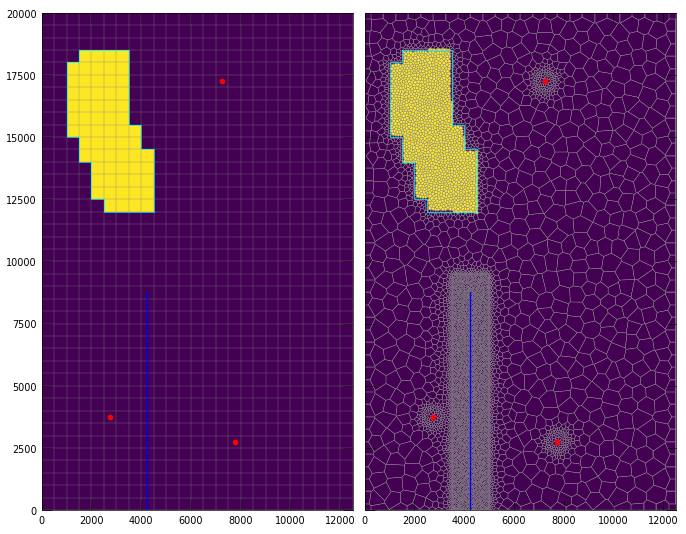

In [39]:
with styles.USGSMap():
    fig, [ax1, ax2] = plt.subplots(
        1,
        2,
        sharey=True,
        figsize=two_panel_figsize,
        constrained_layout=True,
        subplot_kw=dict(aspect="equal"),
    )
    ax = ax1
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(lake_location.get_array(1))
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)

    ax = ax2
    mm = flopy.plot.PlotMapView(modelgrid=voronoi_grid, ax=ax)
    mm.plot_array(lake_cells_vg)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)

    fpth = "figures/mv_voronoi_lake.png"
    plt.savefig(fpth, dpi=300);

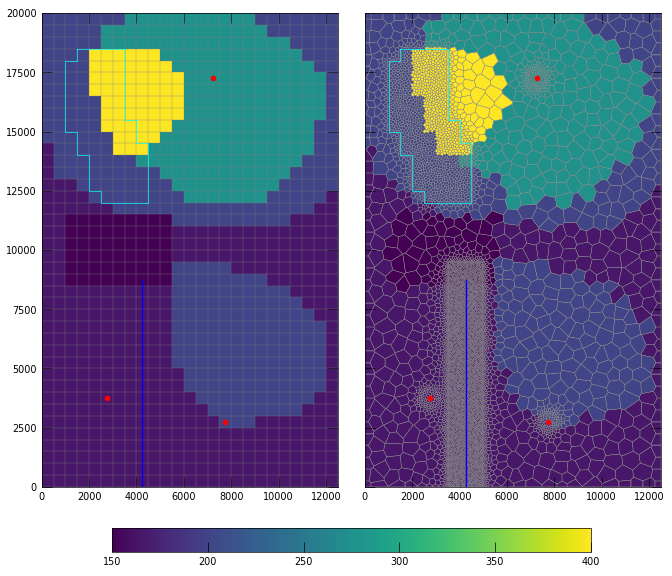

In [86]:
vmin, vmax = kaq.get_array(1).min(), kaq.get_array(1).max()
with styles.USGSMap():
    fig, [ax1, ax2] = plt.subplots(
        1,
        2,
        sharey=True,
        figsize=two_panel_figsize,
        constrained_layout=True,
        subplot_kw=dict(aspect="equal"),
    )
    ax = ax1
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(kaq.get_array(1), vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)

    ax = ax2
    mm = flopy.plot.PlotMapView(modelgrid=voronoi_grid, ax=ax)
    pa = mm.plot_array(kaq_vg, vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)
    
    axs = np.array([ax1, ax2])
    cb = plt.colorbar(
    pa,
    ax=axs[:], # select all axis from second column
    orientation='horizontal',
    shrink=0.75)

    fpth = "figures/mv_voronoi_kaq.png"
    plt.savefig(fpth, dpi=300);

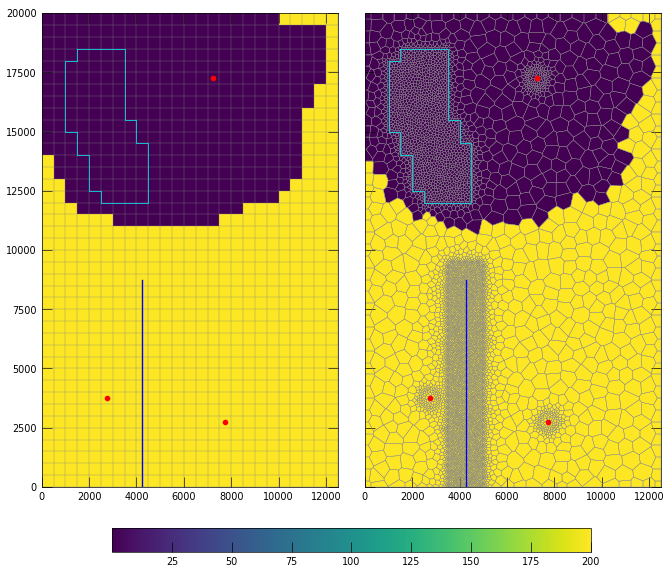

In [87]:
vmin, vmax = kclay.get_array(1).min(), kclay.get_array(1).max()
with styles.USGSMap():
    fig, [ax1, ax2] = plt.subplots(
        1,
        2,
        sharey=True,
        figsize=two_panel_figsize,
        constrained_layout=True,
        subplot_kw=dict(aspect="equal"),
    )
    ax = ax1
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(kclay.get_array(1), vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)

    ax = ax2
    mm = flopy.plot.PlotMapView(modelgrid=voronoi_grid, ax=ax)
    pa = mm.plot_array(kclay_vg, vmin=vmin, vmax=vmax)
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)

    axs = np.array([ax1, ax2])
    cb = plt.colorbar(
    pa,
    ax=axs[:], # select all axis from second column
    orientation='horizontal',
    shrink=0.75)    
    
    fpth = "figures/mv_voronoi_kclay.png"
    plt.savefig(fpth, dpi=300);

### intersect features with the grid

In [42]:
ixs = flopy.utils.GridIntersect(voronoi_grid, method="vertex")
sg_result = ixs.intersect(LineString(sg_densify), sort_by_cellid=False)

In [43]:
sg_result.shape, sg_result["lengths"].sum()

((176,), 8750.0)

### forcing data

In [44]:
rainfall = 0.00821918
evaporation = 0.0062296
net_rainfall = 0.003641

## Build SFR, LAK, DRN, and WEL datasets

SFR datasets

In [45]:
sfr_unit_conversion = 1.486 * 86400.0

In [46]:
sfr_plt_array = np.zeros(voronoi_grid.ncpl, dtype=int)

In [47]:
sfr_nodes = np.arange(0, sg_result.shape[0])
gwf_nodes = sg_result["cellids"][::-1]
sfr_lengths = sg_result["lengths"][::-1]

In [48]:
total_cond = 1800000.0
sfr_width = 10.0
sfr_bedthick = 1.0
sfr_hk = total_cond * sfr_bedthick / (sfr_width * sfr_lengths.sum())
sfr_hk

20.571428571428573

In [49]:
b0, b1 = -0.3, -2.05
sfr_slope = -0.0002
cum_dist = np.zeros(sfr_nodes.shape, dtype=float)
cum_dist[0] = 0.5 * sfr_lengths[0]
for idx in range(1, sfr_nodes.shape[0]):
    cum_dist[idx] = cum_dist[idx - 1] + 0.5 * (
        sfr_lengths[idx - 1] + sfr_lengths[idx]
    )
sfr_bot = b0 + sfr_slope * cum_dist
cum_dist[-1], sfr_lengths.sum(), sfr_lengths[-1], sfr_bot[-1]

(8725.0, 8750.0, 50.0, -2.045)

In [50]:
sfr_conn = []
for idx, node in enumerate(sfr_nodes):
    iconn = [node]
    if idx > 0:
        iconn.append(sfr_nodes[idx - 1])
    if idx < sfr_nodes.shape[0] - 1:
        iconn.append(-sfr_nodes[idx + 1])
    sfr_conn.append(iconn)

In [51]:
# <rno> <cellid(ncelldim)> <rlen> <rwid> <rgrd> <rtp> <rbth> <rhk> <man> <ncon> <ustrf> <ndv>
sfrpak_data = []
for idx, (cellid, rlen, rtp) in enumerate(
    zip(gwf_nodes, sfr_lengths, sfr_bot)
):
    sfr_plt_array[cellid] = 1
    sfrpak_data.append(
        (
            idx,
            (
                0,
                cellid,
            ),
            rlen,
            sfr_width,
            -sfr_slope,
            rtp,
            sfr_bedthick,
            sfr_hk,
            0.030,
            (len(sfr_conn[idx]) - 1),
            1.0,
            0,
        )
    )
sfrpak_data[-2:]

[(174,
  (0, 996),
  25.0,
  10.0,
  0.0002,
  -2.0375,
  1.0,
  20.571428571428573,
  0.03,
  2,
  1.0,
  0),
 (175,
  (0, 990),
  50.0,
  10.0,
  0.0002,
  -2.045,
  1.0,
  20.571428571428573,
  0.03,
  1,
  1.0,
  0)]

In [52]:
sfr_spd = [(node, "rainfall", rainfall) for node in sfr_nodes] + [
    (node, "evaporation", evaporation) for node in sfr_nodes
]

LAK datasets

In [53]:
lak_length_conversion = 3.28081
lak_time_conversion = 86400.0

In [54]:
lake_ic = 11.3
idx = np.where(lake_cells_vg == 1.0)

lake_map = np.ones(voronoi_grid.ncpl, dtype=int) * -1
lake_map[idx] = 0

(idomain, lakpak_dict, lak_connections) = flopy.mf6.utils.get_lak_connections(
    voronoi_grid,
    lake_map,
    bedleak=0.0013,
)

lakpak_data = [(0, lake_ic, lakpak_dict[0])]
lake_spd = [
    (0, "rainfall", rainfall),
    (0, "evaporation", evaporation),
]

In [55]:
lake_ic, lakpak_data

(11.3, [(0, 11.3, 1281)])

In [56]:
lak_connections[0:10]

[[0, 0, (0, 528), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 1, (0, 529), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 2, (0, 530), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 3, (0, 531), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 4, (0, 532), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 5, (0, 533), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 6, (0, 534), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 7, (0, 535), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 8, (0, 536), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0],
 [0, 9, (0, 558), 'vertical', 0.0013, 0.0, 0.0, 0.0, 0.0]]

DRN datasets

In [57]:
areas = []
for idx in range(voronoi_grid.ncpl):
    vertices = np.array(voronoi_grid.get_cell_vertices(idx))
    area = Polygon(vertices).area
    areas.append(area)

In [58]:
drn_kv = 0.1
drn_depth = 1.0
drn_spd = []
for idx, elev in enumerate(top_vg):
    if lake_cells_vg[idx] > 0:
        cond = drn_kv * areas[idx] / drn_depth
        drn_spd.append([(0, idx), elev, cond, -drn_depth])
drn_spd[:10]

[[(0, 528), 10.71999979019165, 1318.0492410471547, -1.0],
 [(0, 529), 10.71999979019165, 1153.1988003798292, -1.0],
 [(0, 530), 10.71999979019165, 1078.28620568127, -1.0],
 [(0, 531), 10.71999979019165, 1243.1366463485956, -1.0],
 [(0, 532), 10.71999979019165, 1153.1988003798292, -1.0],
 [(0, 533), 10.713999843597412, 1153.1988003798292, -1.0],
 [(0, 534), 10.707999897003173, 1264.8793638179873, -1.0],
 [(0, 535), 10.91899995803833, 972.3678657313915, -1.0],
 [(0, 536), 11.347000026702881, 1129.4239582167347, -1.0],
 [(0, 558), 10.860000133514404, 1153.1988003798358, -1.0]]

WEL datasets

In [59]:
well_points

[(7250.0, 17250.0), (7750.0, 2750.0), (2750.0, 3750.0)]

In [60]:
well_loc = []
for x, y in well_points:
    well_loc.append(voronoi_grid.intersect(x, y))
well_loc

[6639, 6906, 6638]

In [61]:
# first well is Virginia City well site 2
# second well is Reilly well
# third well is Virginia City well site 1
boundname = ["VC2", "Reilly", "VC1"]
rates = [-67000.0, -268000.0, -268000.0]
welspd = [
    [4, cellid, rates[idx], boundname[idx]]
    for idx, cellid in enumerate(well_loc)
]
welspd

[[4, 6639, -67000.0, 'VC2'],
 [4, 6906, -268000.0, 'Reilly'],
 [4, 6638, -268000.0, 'VC1']]

## Plot a series of grids

In [62]:
def add_subdomain(ax, xll, xur, yll, yur, lw=0.75, color="black", text="B"):
    x = [xll, xll, xur, xur, xll]
    y = [yll, yur, yur, yll, yll]
    ax.plot(x, y, lw=lw, color=color)
    styles.add_text(
        ax=ax,
        text=text,
        x=xll,
        y=yur,
        color=color,
        transform=False,
        ha="right",
        va="bottom",
        italic=False,
    )

In [63]:
def add_nodes(ax, xll, xur, yll, yur, edge=20.0, text_offset=2.0):
    for idx, (x, y) in enumerate(zip(xcv, ycv)):
        if x > xll and x < xur and y > yll and y < yur:
            ax.plot(x, y, marker=".", markersize=4, color="black")
            if (
                x > xll + edge
                and x < xur - edge
                and y > yll
                and y < yur - edge
            ):
                xt = x + 4 * text_offset
                yt = y + text_offset
                styles.add_text(
                    ax=ax,
                    x=xt,
                    y=yt,
                    text=f"{idx + 1}",
                    bold=False,
                    transform=False,
                    ha="center",
                    va="bottom",
                    fontsize=5,
                )

In [64]:
def set_ticklabels(
    ax,
    fmt="{:.1f}",
    skip_xticklabels=False,
    skip_yticklabels=False,
    skip_xlabel=False,
    skip_ylabel=False,
    xticks=None,
    yticks=None,
):
    if xticks is None:
        labels = [ax.get_xticks().tolist()]
    else:
        ax.set_xticks(xticks, labels=[str(value) for value in xticks])
        labels = [xticks]

    if yticks is None:
        labels += [ax.get_yticks().tolist()]
    else:
        ax.set_yticks(yticks, labels=[str(value) for value in yticks])
        labels += [yticks]

    for idx, label in enumerate(labels):
        for jdx, value in enumerate(label):
            labels[idx][jdx] = fmt.format(float(value) / 1000.0)

    if skip_xticklabels:
        ax.set_xticklabels([])
    else:
        ax.xaxis.set_major_locator(mticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(labels[0])

    if skip_yticklabels:
        ax.set_yticklabels([])
    else:
        ax.yaxis.set_major_locator(mticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(labels[1])

    if not skip_xlabel:
        ax.set_xlabel("x position (km)")
    if not skip_ylabel:
        ax.set_ylabel("y position (km)")

A few coordinates for plotting

In [65]:
xcv, ycv = voronoi_grid.xcellcenters, voronoi_grid.ycellcenters

In [66]:
x0 = x1 = sg[:, 0].min()
y0, y1 = sg[:, 1].max(), sg[:, 1].min()
x0, y0, x1, y1

(4250.0, 8750.0, 4250.0, 0.0)

Plot river mapping

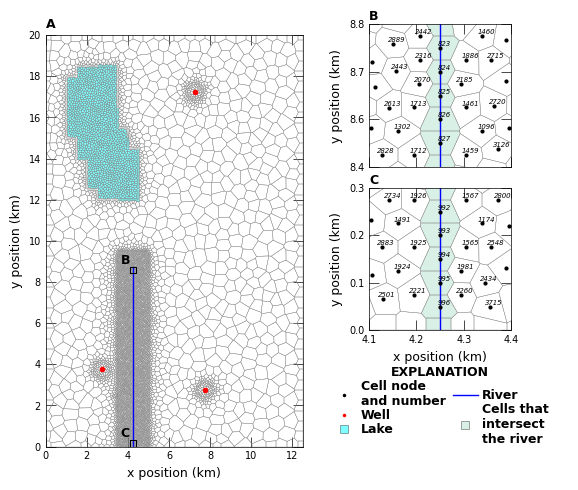

In [67]:
dv = 150.0
cmap = "viridis"

with styles.USGSMap():
    fig = plt.figure(figsize=two_panel_figsize, constrained_layout=False)
    gs = gridspec.GridSpec(ncols=10, nrows=24, figure=fig)
    ax0 = fig.add_subplot(gs[:, :5])
    ax2 = fig.add_subplot(gs[9:17, 5:])
    ax1 = fig.add_subplot(gs[0:8, 5:], sharex=ax2)
    # ax1.get_shared_x_axes().join(ax1, ax2)
    ax3 = fig.add_subplot(gs[17:, 5:])

    ax = ax0
    ax.set_aspect("equal", "box")
    styles.heading(ax=ax, idx=0)
    mm = flopy.plot.PlotMapView(modelgrid=voronoi_grid, ax=ax)
    mm.plot_array(
        lake_cells_vg,
        masked_values=[
            0,
        ],
        cmap=lake_cmap,
        alpha=0.5,
    )
    mm.plot_grid(**grid_dict)
    plot_river(ax)
    plot_wells(ax, ms=3)
    xticks = np.arange(mm.extent[0], mm.extent[1], 2000.0).tolist()
    yticks = np.arange(mm.extent[2], mm.extent[3] + 2000.0, 2000.0).tolist()
    set_ticklabels(ax, fmt="{:.0f}", xticks=xticks, yticks=yticks)

    ax = ax1
    ax.set_aspect("equal", "box")
    plt.setp(ax.get_xticklabels(), visible=False)
    styles.heading(ax=ax, idx=1)

    xll, xur = x0 - dv, x1 + dv
    yll, yur = y0 - 2.0 * dv, y0
    xticks = np.arange(xll, xur + 100, 100.0).tolist()
    yticks = np.arange(yll, yur + 100, 100.0).tolist()
    add_subdomain(ax0, xll, xur, yll, yur, text="B")

    mm = flopy.plot.PlotMapView(
        modelgrid=voronoi_grid, ax=ax, extent=(xll, xur, yll, yur)
    )
    mm.plot_array(
        sfr_plt_array,
        lw=0,
        alpha=0.5,
        masked_values=[0],
        cmap=intersection_cmap,
    )
    mm.plot_grid(**grid_dict)
    plot_river(ax)
    add_nodes(ax, xll, xur, yll, yur)
    set_ticklabels(ax, yticks=yticks, skip_xlabel=True)

    ax = ax2
    ax.set_aspect("equal", "box")
    styles.heading(ax=ax, idx=2)

    xll, xur = x0 - dv, x1 + dv
    yll, yur = y1, y1 + 2.0 * dv
    yticks = np.arange(yll, yur + 100.0, 100.0).tolist()
    add_subdomain(ax0, xll, xur, yll, yur, text="C")

    mm = flopy.plot.PlotMapView(
        modelgrid=voronoi_grid, ax=ax, extent=(xll, xur, yll, yur)
    )
    mm.plot_array(
        sfr_plt_array,
        lw=0,
        alpha=0.5,
        masked_values=[0],
        cmap=intersection_cmap,
    )
    mm.plot_grid(**grid_dict)
    plot_river(ax)
    add_nodes(ax, xll, xur, yll, yur)
    set_ticklabels(ax, xticks=xticks, yticks=yticks)

    # legend
    ax = ax3
    xy0 = (-100, -100)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    # fake data to set up legend
    ax.plot(
        xy0,
        xy0,
        lw=0.0,
        marker=".",
        ms=5,
        mfc="black",
        mec="none",
        mew=0.0,
        label="Cell node\nand number",
    )
    ax.plot(
        xy0,
        xy0,
        lw=0.0,
        marker=".",
        ms=5,
        mfc="red",
        mec="none",
        mew=0.0,
        label="Well",
    )
    ax.plot(
        xy0,
        xy0,
        lw=0.0,
        marker="s",
        mfc="cyan",
        mec="black",
        mew=0.5,
        alpha=0.5,
        label="Lake",
    )
    ax.axhline(xy0[0], **river_dict, label="River")
    ax.plot(
        xy0,
        xy0,
        lw=0.0,
        marker="s",
        mfc=intersection_rgba,
        mec="black",
        mew=0.5,
        alpha=0.5,
        label="Cells that\nintersect\nthe river",
    )
    styles.graph_legend(
        ax,
        ncol=2,
        loc="lower center",
        labelspacing=0.1,
        columnspacing=0.6,
        handletextpad=0.3,
    )

    # save the figure
    fpth = "../doc/figures/mv_voronoi_river_discretization.png"
    plt.savefig(fpth, dpi=300);

## Build the Model

In [68]:
ws = "./temp/mv_voronoi"
name = "mv"
exe_name = "mf6"
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name=exe_name)
tdis = flopy.mf6.ModflowTdis(sim, time_units="days")
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="all",
    complexity="complex",
    # under_relaxation="simple",
    # under_relaxation_gamma=0.90,
    outer_dvclose=1e-3,
    outer_maximum=200,
    linear_acceleration="bicgstab",
    inner_dvclose=1e-4,
    inner_maximum=200,
    rcloserecord="1e-2 strict",
    #     preconditioner_levels=8,
    #     preconditioner_drop_tolerance=1e-4,
)
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=name,
    save_flows=True,
    newtonoptions="NEWTON UNDER_RELAXATION",
)
dis = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=vor.ncpl,
    nvert=vor.nverts,
    top=top_vg,
    botm=[-5, -50, -51, -100.0, bot_vg],
    vertices=vor.get_disv_gridprops()["vertices"],
    cell2d=vor.get_disv_gridprops()["cell2d"],
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.0)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=True,
    save_specific_discharge=True,
    icelltype=[1, 0, 0, 0, 0],
    k=[kaq_vg, kaq_vg, kclay_vg, kaq_vg, kaq_vg],
    k33=[0.25 * kaq_vg, 0.25 * kaq_vg, kclay_vg, 0.25 * kaq_vg, 0.25 * kaq_vg],
)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rainfall)
evt = flopy.mf6.ModflowGwfevta(
    gwf, surface=top_vg, rate=evaporation, depth=1.0
)
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=welspd, boundnames=True)
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    auxiliary=["depth"],
    auxdepthname="depth",
    stress_period_data=drn_spd,
)
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    print_stage=True,
    print_flows=True,
    unit_conversion=sfr_unit_conversion,
    stage_filerecord="{}.sfr.stage.bin".format(name),
    budget_filerecord="{}.sfr.cbc".format(name),
    nreaches=len(sfrpak_data),
    packagedata=sfrpak_data,
    connectiondata=sfr_conn,
    perioddata=sfr_spd,
)
lak = flopy.mf6.ModflowGwflak(
    gwf,
    time_conversion=lak_time_conversion,
    length_conversion=lak_length_conversion,
    print_stage=True,
    print_flows=True,
    stage_filerecord="{}.lak.stage.bin".format(name),
    budget_filerecord="{}.lak.cbc".format(name),
    nlakes=1,
    packagedata=lakpak_data,
    connectiondata=lak_connections,
    perioddata=lake_spd,
)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=name + ".hds",
    budget_filerecord=name + ".bud",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("BUDGET", "ALL")],
)
# write the model datasets
sim.write_simulation()

# run the model
success = sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mv...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package evta_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 3 based on size of stress_period_data
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 1281 based on size of stress_period_data
    writing package sfr_0...
    writing package lak_0...
    writing package oc...
FloPy is using the following executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.4.0 release candidate 05/19/2022
                               ***DEVELOP MODE***

   MODFLOW 6 comp

### process model results

In [69]:
lake_stage = float(gwf.lak.output.stage().get_data().squeeze())
lake_stage

11.342850266024678

In [70]:
head = gwf.output.head().get_data().squeeze()
head.shape, head.min(), head.max()

((5, 8483), -4.034773737003246, 15.259145739519456)

In [71]:
cbc = gwf.output.budget()
cbc.list_unique_records(), cbc.list_unique_packages()

RECORD           IMETH
----------------------
FLOW-JA-FACE         1
DATA-SPDIS           6
WEL                  6
DRN                  6
RCHA                 6
EVTA                 6
SFR                  6
LAK                  6

NPF             
MV              


(None, None)

In [72]:
spdis = cbc.get_data(text="DATA-SPDIS")[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    spdis, gwf, head=head
)
qx.shape

(5, 8483)

In [73]:
lake_q = cbc.get_data(text="LAK", full3D=True)[0]
lake_q.shape

(5, 8483)

In [74]:
lake_q_dir = np.zeros(lake_q.shape, dtype=int)
lake_q_dir[lake_q < 0.0] = -1
lake_q_dir[lake_q > 0.0] = 1

#### adjust head to be lake stage in layer 1 where lake stage is greater than topo

idx = (lake_cells_vg > 0) & (top_vg <= lake_stage)
h = head[0].copy()
h[idx] = lake_stage
head[0] = h.copy()

#### plot top of model and results

In [75]:
top_range = (5, 65)
top_levels = np.arange(10, 70, 10)
head_range = (-4, 14)
head_levels = np.arange(2, head_range[1] + 2, 2)

xticks = np.arange(
    voronoi_grid.extent[0], voronoi_grid.extent[1], 2000.0
).tolist()
yticks = np.arange(
    voronoi_grid.extent[2], voronoi_grid.extent[3] + 2000.0, 2000.0
).tolist()

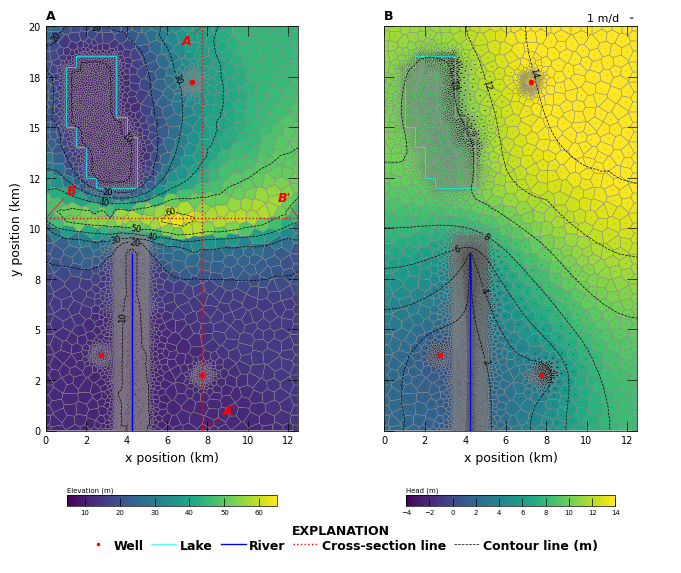

In [76]:
with styles.USGSMap():
    fig = plt.figure(figsize=two_panel_figsize, constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=24, figure=fig)
    ax0 = fig.add_subplot(gs[:22, 0])
    ax1 = fig.add_subplot(gs[:22, 1])
    ax2 = fig.add_subplot(gs[22:, :])

    for ax in (ax0, ax1):
        ax.set_aspect("equal", "box")

    # topography
    ax = ax0
    styles.heading(ax=ax, idx=0)
    mm = flopy.plot.PlotMapView(
        model=gwf,
        ax=ax,
        extent=voronoi_grid.extent,
    )
    cb = mm.plot_array(top_vg, vmin=top_range[0], vmax=top_range[1])
    mm.plot_grid(**grid_dict)
    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)
    cs = mm.contour_array(
        top_vg,
        **mv_contour_dict,
        levels=top_levels,
    )
    ax.clabel(
        cs,
        **clabel_dict,
    )
    set_ticklabels(ax, fmt="{:.0f}")

    # topography colorbar
    cbar = plt.colorbar(cb, ax=ax, orientation="horizontal", shrink=0.65)
    cbar.ax.tick_params(
        labelsize=5,
        labelcolor="black",
        color="black",
        length=6,
        pad=2,
    )
    cbar.ax.set_title(
        "Elevation (m)",
        pad=2.5,
        loc="left",
        fontdict=font_dict,
    )

    # cross-section lines
    dlabel = 400
    ax.plot(
        [7750.0, 7750.0],
        [voronoi_grid.extent[3], 0],
        lw=1,
        ls=":",
        color="red",
    )
    styles.add_annotation(
        ax=ax,
        text="A",
        xy=(7750, voronoi_grid.extent[3]),
        xytext=(-15, -15),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )
    styles.add_annotation(
        ax=ax,
        text="A'",
        xy=(7750, 0),
        xytext=(15, 10),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )
    mm.ax.plot(
        [0, voronoi_grid.extent[1]], [10500, 10500], lw=1, ls=":", color="red"
    )
    styles.add_annotation(
        ax=ax,
        text="B",
        xy=(0, 10500),
        xytext=(15, 15),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )
    styles.add_annotation(
        ax=ax,
        text="B'",
        xy=(voronoi_grid.extent[1], 10500),
        xytext=(-15, 10),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )

    # head
    ax = ax1
    styles.heading(ax=ax, idx=1)
    mm = flopy.plot.PlotMapView(
        model=gwf,
        ax=ax,
        extent=voronoi_grid.extent,
    )
    cb = mm.plot_array(head, vmin=head_range[0], vmax=head_range[1])
    # lp = mm.plot_array(lake_q_dir, masked_values=[0], cmap=drain_cmap, edgecolor="none", vmin=0.5, vmax=2.5,)

    mm.plot_grid(**grid_dict)
    q = mm.plot_vector(qx, qy, normalize=False)
    qk = plt.quiverkey(
        q,
        0.97,
        1.02,
        1,
        label="1 m/d",
        labelpos="W",
        labelcolor="black",
        fontproperties={"size": 8},
    )

    plot_wells(ax=ax, ms=3)
    plot_river(ax=ax)
    plot_lake(ax=ax)
    cs = mm.contour_array(
        head,
        **mv_contour_dict,
        levels=head_levels,
    )
    ax.clabel(
        cs,
        **clabel_dict,
    )
    set_ticklabels(ax, fmt="{:.0f}", skip_yticklabels=True, skip_ylabel=True)

    # head colorbar
    cbar = plt.colorbar(cb, ax=ax, orientation="horizontal", shrink=0.65)
    cbar.ax.tick_params(
        labelsize=5,
        labelcolor="black",
        color="black",
        length=6,
        pad=2,
    )
    cbar.ax.set_title(
        "Head (m)",
        pad=2.5,
        loc="left",
        fontdict=font_dict,
    )

    # legend
    ax = ax2
    xy0 = (-100, -100)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_axis_off()

    # fake data to set up legend
    ax.plot(
        xy0,
        xy0,
        lw=0.0,
        marker=".",
        ms=5,
        mfc="red",
        mec="none",
        mew=0.0,
        label="Well",
    )
    ax.axhline(xy0[0], color="cyan", lw=0.5, label="Lake")
    ax.axhline(xy0[0], **river_dict, label="River")
    ax.axhline(xy0[0], lw=1, ls=":", color="red", label="Cross-section line")
    ax.axhline(xy0[0], **contour_label_dict, label="Contour line (m)")
    styles.graph_legend(
        ax,
        ncol=5,
        loc="lower center",
        labelspacing=0.1,
        columnspacing=0.6,
        handletextpad=0.3,
    )

    fpth = "../doc/figures/mv_voronoi_map.png"
    plt.savefig(fpth, dpi=300);

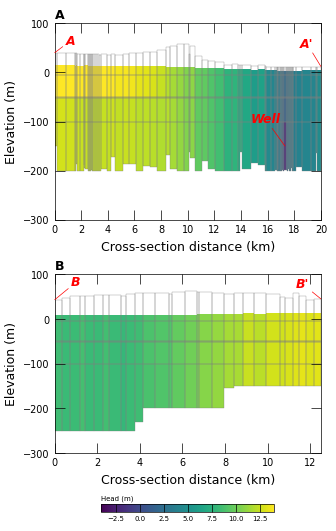

In [77]:
with styles.USGSMap():
    fig = plt.figure(figsize=one_panel_figsize, constrained_layout=True)
    gs = gridspec.GridSpec(ncols=1, nrows=21, figure=fig)
    ax0 = fig.add_subplot(gs[:11, :])
    ax1 = fig.add_subplot(gs[11:22, :])

    # cross-section A-A'
    ax = ax0
    styles.heading(ax, idx=0)
    fx = flopy.plot.PlotCrossSection(
        model=gwf,
        ax=ax,
        line={
            "line": [
                (7750, voronoi_grid.extent[3]),
                (7750, voronoi_grid.extent[2]),
            ]
        },
    )
    fx.plot_array(head, head=head, vmin=head_range[0], vmax=head_range[1])
    fx.plot_grid(**grid_dict)

    ax.set_ylim(-300, 100)
    xs_xticks = np.arange(0, ax.get_xlim()[1], 2000)
    ax.set_xticks(xs_xticks, labels=[f"{x/1000:.0f}" for x in xs_xticks])
    ax.set_xlabel("Cross-section distance (km)")
    ax.set_ylabel("Elevation (m)")

    # annotation
    styles.add_annotation(
        ax=ax,
        text="A",
        xy=(0, 40),
        xytext=(8, 4),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )
    styles.add_annotation(
        ax=ax,
        text="A'",
        xy=(ax.get_xlim()[1], 12),
        xytext=(-15, 12),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )
    styles.add_annotation(
        ax=ax,
        text="Well",
        xy=(ax.get_xlim()[1] - 2700, -150),
        xytext=(-25, 15),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )

    # cross-section B-B'
    ax = ax1
    styles.heading(ax, idx=1)
    fx = flopy.plot.PlotCrossSection(
        model=gwf,
        ax=ax,
        line={"line": [(0, 10500), (12500, 10500)]},
    )
    hv = fx.plot_array(head, head=head, vmin=head_range[0], vmax=head_range[1])
    fx.plot_grid(**grid_dict)

    ax.set_ylim(-300, 100)
    ax.set_xlim(0, 12500)
    xs_xticks = np.arange(0, ax.get_xlim()[1], 2000)
    ax.set_xticks(xs_xticks, labels=[f"{x/1000:.0f}" for x in xs_xticks])
    ax.set_xlabel("Cross-section distance (km)")
    ax.set_ylabel("Elevation (m)")

    # annotation
    styles.add_annotation(
        ax=ax,
        text="B",
        xy=(0, 43),
        xytext=(12, 8),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )
    styles.add_annotation(
        ax=ax,
        text="B'",
        xy=(ax.get_xlim()[1], 45),
        xytext=(-18, 6),
        textcoords="offset points",
        arrowprops=arrowprops,
        bold=True,
        color="red",
    )

    # head colorbar
    cbar = plt.colorbar(hv, ax=ax, orientation="horizontal", shrink=0.65)
    cbar.ax.tick_params(
        labelsize=5,
        labelcolor="black",
        color="black",
        length=6,
        pad=2,
    )
    cbar.ax.set_title(
        "Head (m)",
        pad=2.5,
        loc="left",
        fontdict=font_dict,
    )

    fig.align_labels()

    fpth = "../doc/figures/mv_voronoi_xsection.png"
    plt.savefig(fpth, dpi=300);

In [78]:
voronoi_grid.extent, gwf.modelgrid.extent

((0.0, 12500.0, 0.0, 20000.0), (0.0, 12500.0, 0.0, 20000.0))

(0.0, 20000.000000000015, -250.00000000000006, 63.3194461098495)

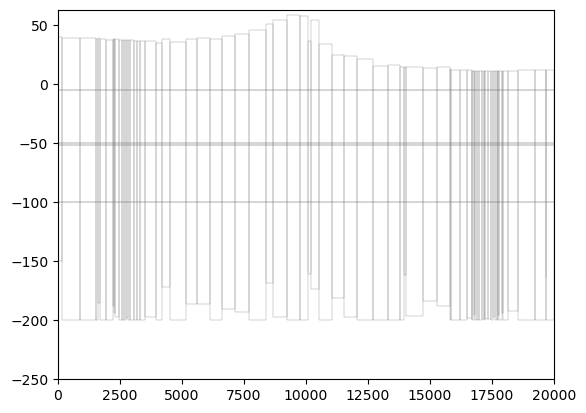

In [79]:
fx = flopy.plot.PlotCrossSection(
    model=gwf,
    line={
        "line": [
            (7750, voronoi_grid.extent[3]),
            (7750, voronoi_grid.extent[2]),
        ]
    },
)
fx.plot_grid(**grid_dict);
fx.get_extent()

(0.0, 20000.0, -250.00000000000006, 63.3194461098495)

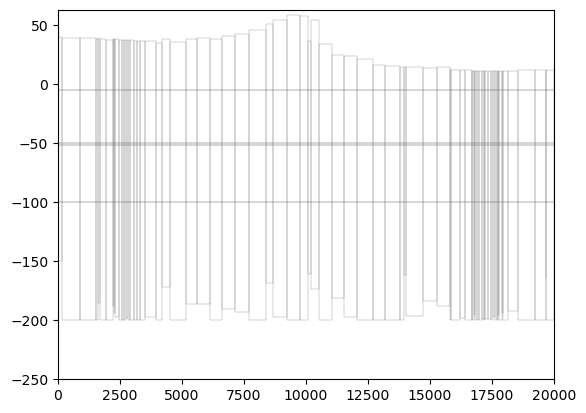

In [80]:
fx = flopy.plot.PlotCrossSection(
    model=gwf,
    line={
        "line": [
            (7750, 21000),
            (7750, -1000),
        ]
    },
)
fx.plot_grid(**grid_dict);
fx.get_extent()

(0.0, 12500.0, -250.00000000000006, 63.3194461098495)

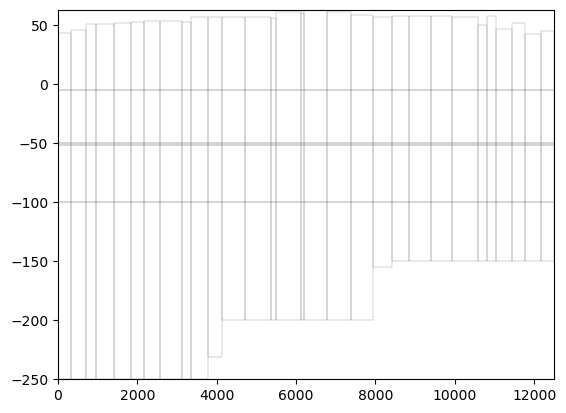

In [81]:
fx = flopy.plot.PlotCrossSection(
    model=gwf,
    line={"line": [(0, 10500), (12500, 10500)]},
    geographic_coords=True,
)
fx.plot_grid(**grid_dict)
fx.get_extent()

(0.0, 12500.0, -250.00000000000006, 63.3194461098495)

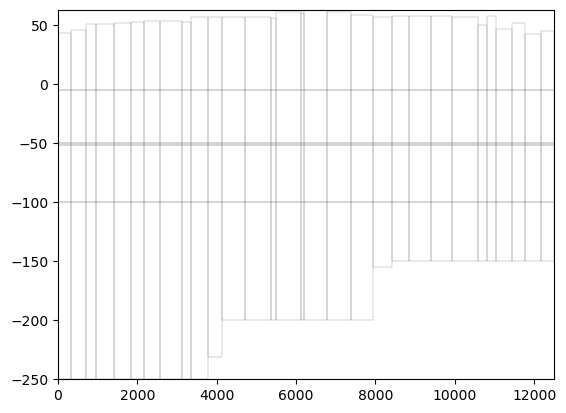

In [82]:
fx = flopy.plot.PlotCrossSection(
    model=gwf,
    line={"line": [(-100, 10500), (12600, 10500)]},
    geographic_coords=True,
)
fx.plot_grid(**grid_dict)
fx.get_extent()